# Manejo de Datos Faltantes: Imputación

## Configuración de ambiente de trabajo

In [1]:
# !pip install --upgrade pip
# !pip install pyjanitor matplotlib==3.5.1 missingno numpy pandas pyreadr seaborn session-info upsetplot==0.6.1

## Importar librerías

In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info

import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

/home/pimarlon21/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/pimarlon21/anaconda3/envs/py/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## Importar funciones personalizadas

In [3]:
import Pandas_Missing_Extension as pme

## Configurar el aspecto general de las gráficas del proyecto

In [4]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

/home/pimarlon21/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/pimarlon21/anaconda3/envs/py/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## El problema de trabajar con valores faltantes

In [5]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [6]:
(
    smf.ols(
        formula="temp ~ ozone",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Wed, 22 Mar 2023",Prob (F-statistic):,2.93e-18
Time:,05:09:04,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [7]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Wed, 22 Mar 2023",Prob (F-statistic):,1.47e-16
Time:,05:09:04,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

In [8]:
%store -r nhanes_df

## Consideración y evaluación de los distintos tipos de valores faltantes

![Missing data action](./missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    <ul>
        <li><code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.
        </li>
        <li><code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
        <li><code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.
        </li>
    </ul>
    </p>
</div>

In [9]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column("weight", lambda x: x.isna(), elementwise = False)
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)

Ttest_indResult(statistic=-0.7659832227497865, pvalue=0.443708373452089)

## Amplía tu conjunto de herramientas para explorar valores faltantes

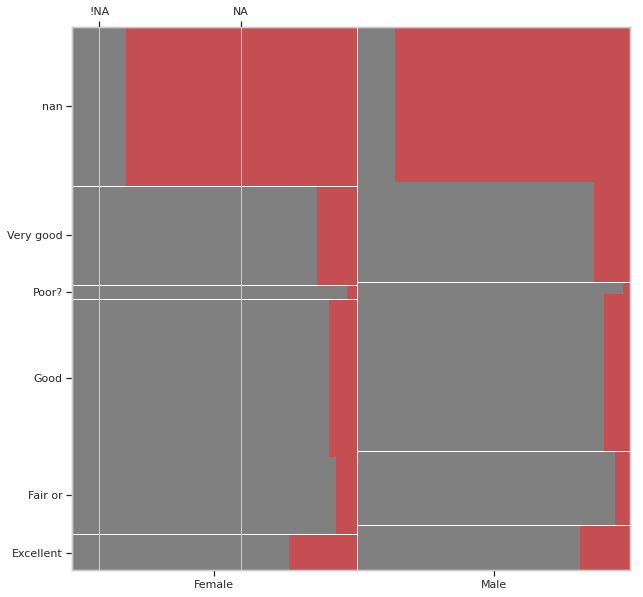

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select_columns("weight", "general_health_condition", "gender")
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))
    .groupby(
        ["gender", "general_health_condition", "weight"], dropna=False, as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "gray"},
            ax=ax,
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
        )
    )
)

ax.grid(False)

## Tratamiento de variables categóricas para imputación de valores faltantes

In [11]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <br>
    <br>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>

    LabelEncoder
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [12]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"],  ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [13]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [14]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [15]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [16]:
categorical_columns = nhanes_df.select_dtypes(object).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [17]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [18]:
nhanes_transformed_df = \
(
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [19]:
gender_encoder = sklearn.preprocessing.OrdinalEncoder()

gender_values = (
    nhanes_df
    .gender
    .values
    .reshape(-1, 1)
)

(
    gender_encoder
    .fit_transform(
        X = gender_values
    )
    .squeeze()
)

(
    nhanes_df.gender.unique(),
    nhanes_transformed_df.gender.unique(),
    gender_encoder.categories_
)

(array(['Female', 'Male'], dtype=object),
 array([0., 1.]),
 [array(['Female', 'Male'], dtype=object)])

### _One Hot Encoding_

In [20]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [21]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    # .head(10)
    .pipe(pd.get_dummies)
    # .columns
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93703.0,0,0,0,0,0
93704.0,0,0,0,0,0
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
...,...,...,...,...,...
102951.0,0,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `skelearn.preprocessing.OneHotEncoder()`

In [22]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [23]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 ['gender']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['general_health_condition'])])

In [24]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93703.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102951.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [25]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [26]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

<ul>
    <li><i>Imputación basada en Donante:</i> Completa los valores faltantes para una variables dada copiando los valores observados, el donante.
    <li><i>Imputación basada en Modelos:</i> Completa los valores faltantes para una variable dada usando un modelo predictivo para la variable objetivo en el conjunto de datos que contiene valores faltantes.
    </li>
    </li>
</ul>

![Imputation types](./imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

In [27]:
(
    nhanes_df
    .transform_column( # janitor
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676384

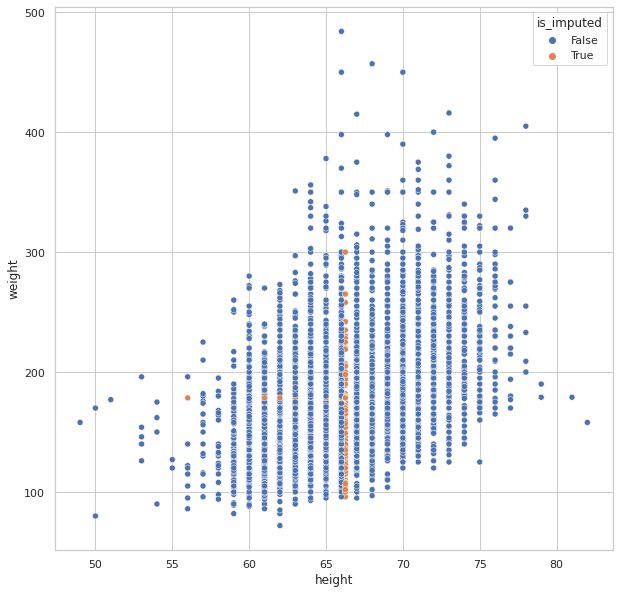

In [28]:
plt.figure(figsize=(10, 10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True,False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

plt.show()

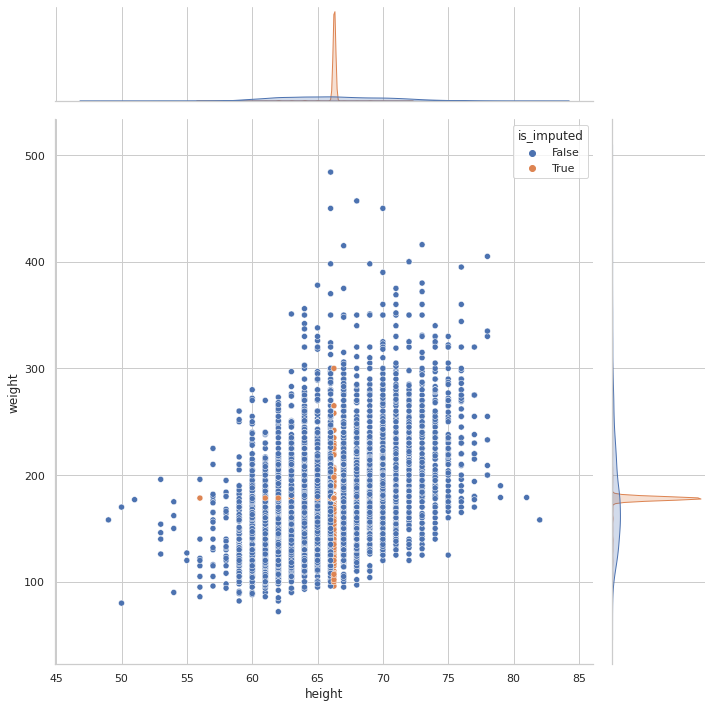

In [29]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(value=df.height.mean()),
        weight=lambda df: df.weight.fillna(value=df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

plt.show()

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [30]:
(
    nhanes_df
    .select_columns("height", "weight")
    .fillna(method = "ffill")
    # .ffill()
)

,height,weight
SEQN,,
93703.0,NaN,NaN
93704.0,NaN,NaN
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
...,...,...
102951.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [31]:
(
    nhanes_df
    .select_columns("height", "weight")
    .fillna(method = "bfill")
    # .bfill()
)

,height,weight
SEQN,,
93703.0,63.0,165.0
93704.0,63.0,165.0
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
...,...,...
102951.0,65.0,218.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [32]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
        .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,NaN,175.0,Male,1,NaN
97267.0,NaN,175.0,Male,1,NaN


## Imputación por interpolación

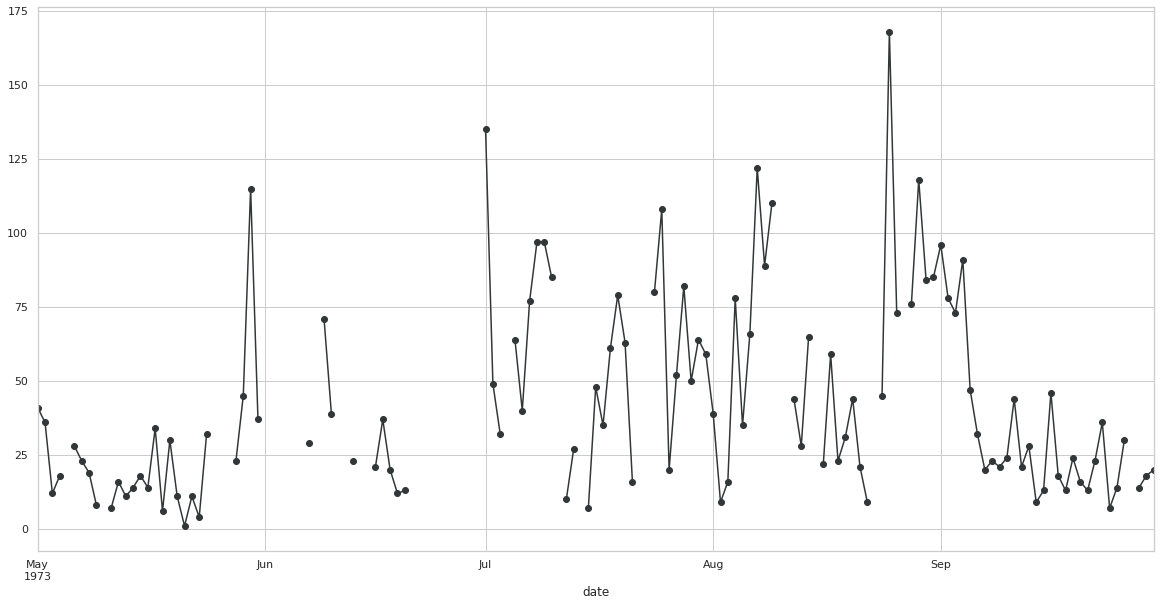

In [33]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

plt.show()

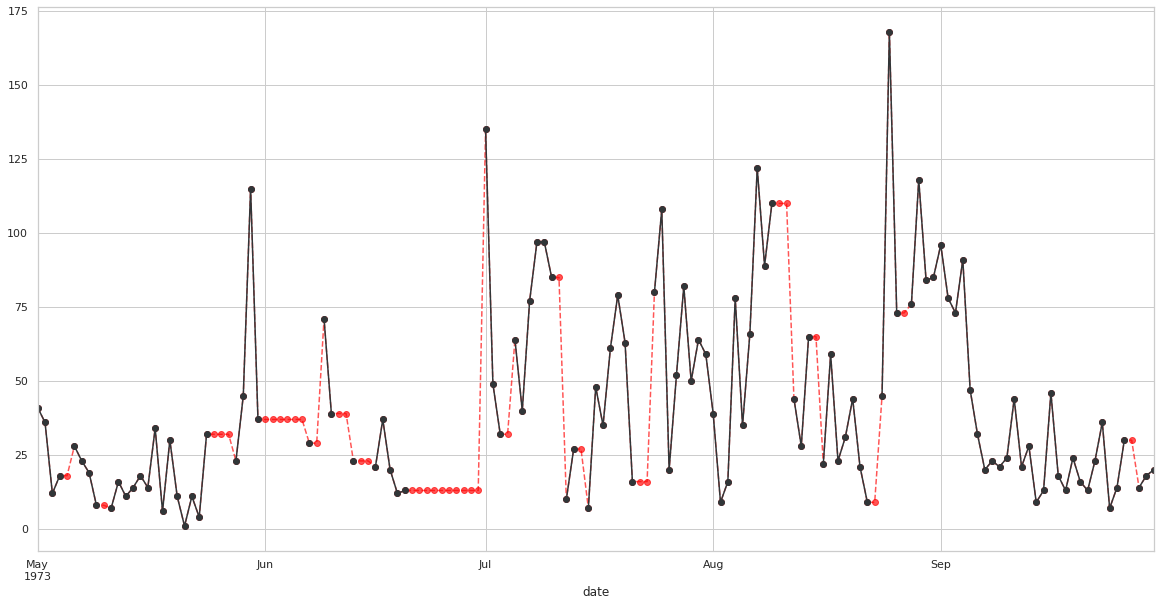

In [34]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

plt.show()

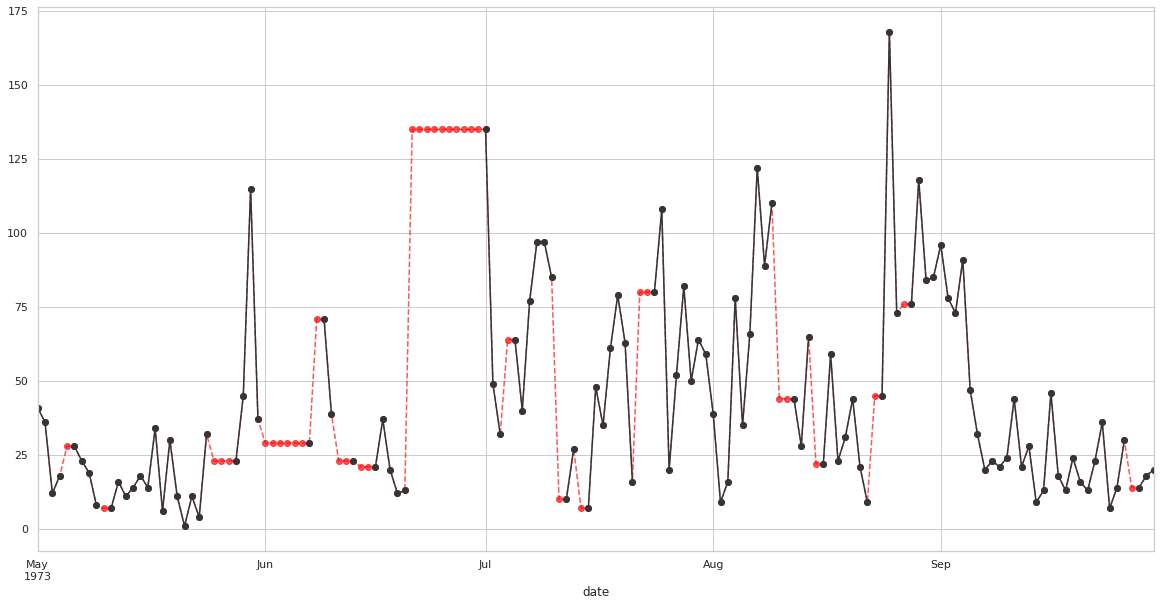

In [35]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

plt.show()

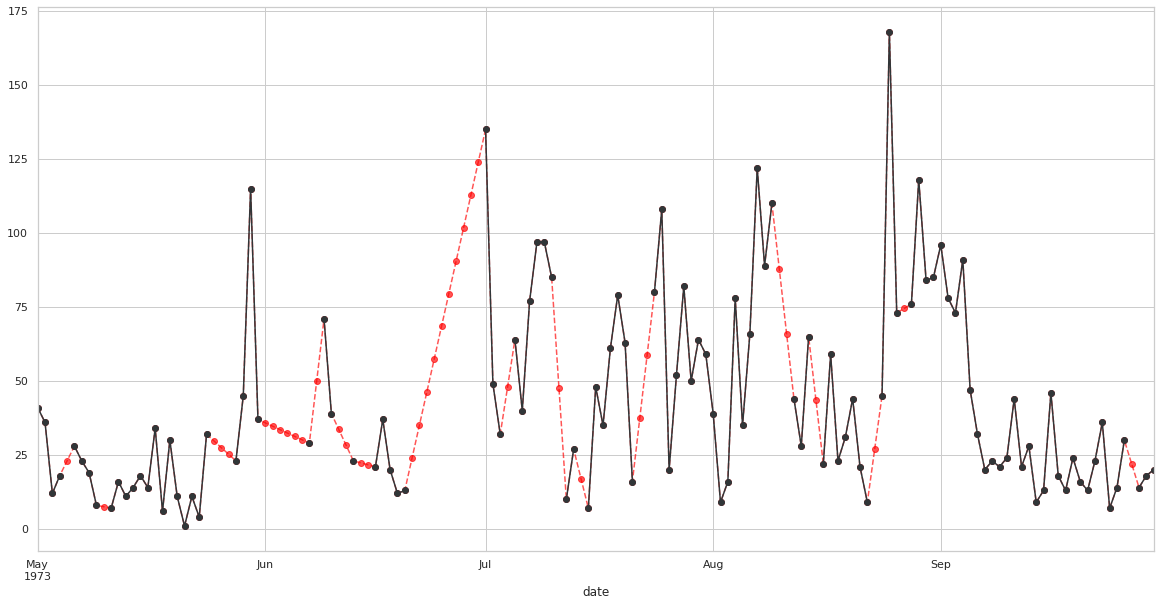

In [36]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "linear").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

plt.show()

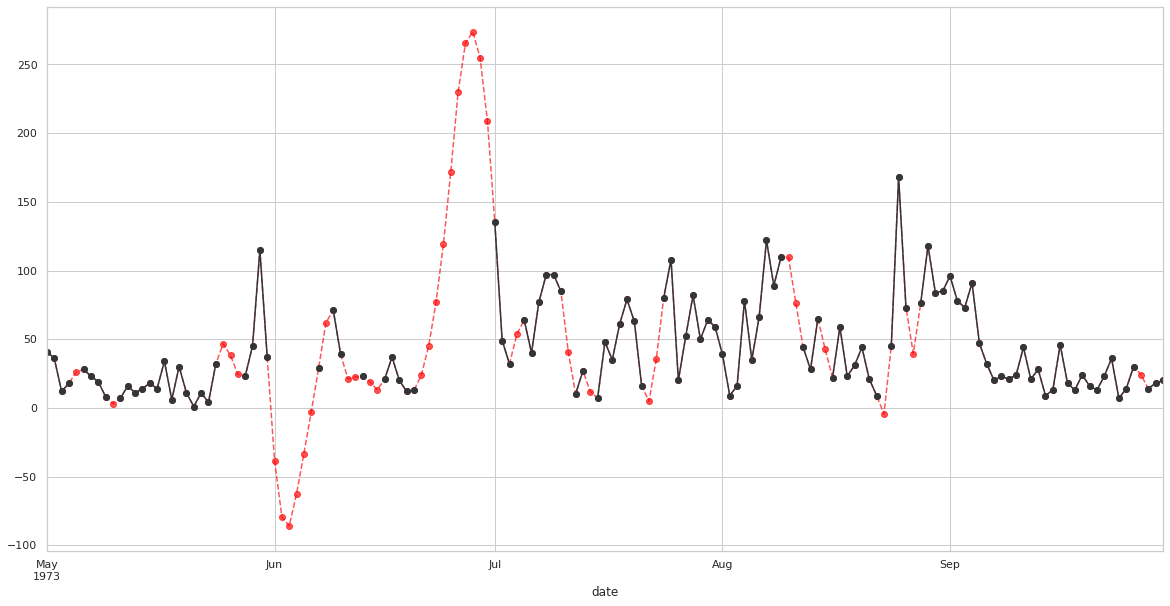

In [37]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "quadratic").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

plt.show()

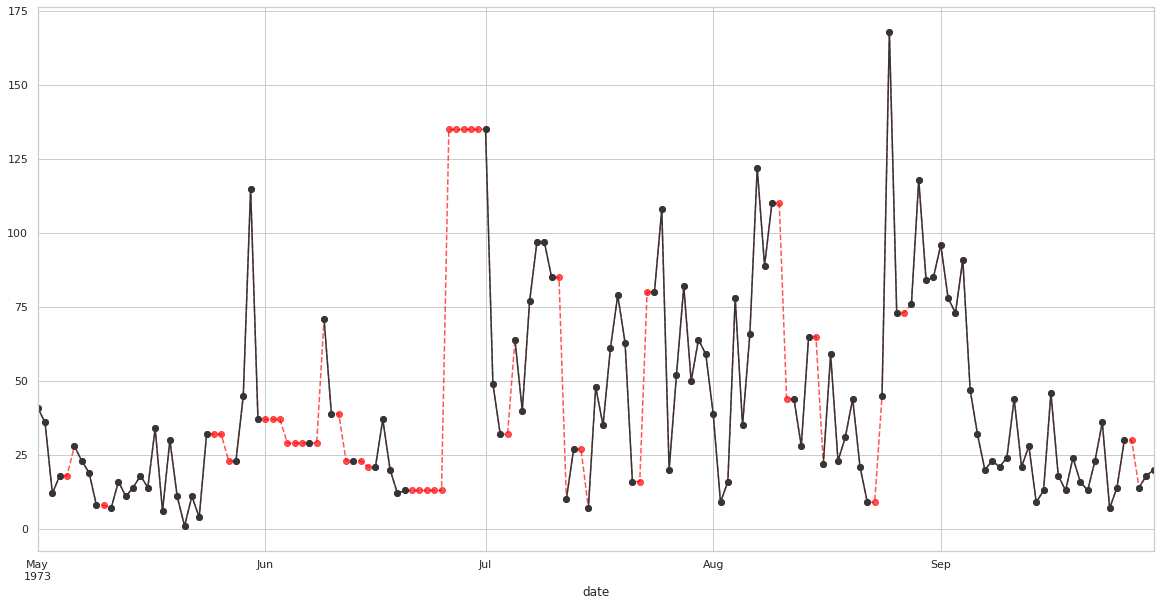

In [38]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "nearest").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

plt.show()

## Imputación por algoritmo de vecinos más cercanos (KNN)

<ol>
    <li><i>Pros:</i></li>
        <ul>
            <li>Implementación sencilla.</li>
            <li>Buen rendimiento con conjuntos de datos pequeños.</li>
            <li>Excelente para datos númericos, pero también funciona con datos mixtos.</li>
        </ul>
    <li><i>Cons:</i></li>
        <ul>
            <li>Escalabilidad puede verse comprometida dependiendo del número de filas y columnas.</li>
            <li>Requiere transformaciones especiales para las variables categóricas.</li>
            <li>Sensibilidad a valores atípicos.</li>
        </ul>
</ol>

In [39]:
nhanes_df.head()

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male


In [40]:
nhanes_df_knn = nhanes_transformed_df.copy(deep=True)
nhanes_df_knn.head()

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0


In [41]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,2.0,0.0,63.0,137.0,151.0,91.0,0.0,2.0
93704.0,2.0,1.0,71.0,152.0,164.0,86.0,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,2.0,1.0,71.0,152.0,164.0,86.0,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


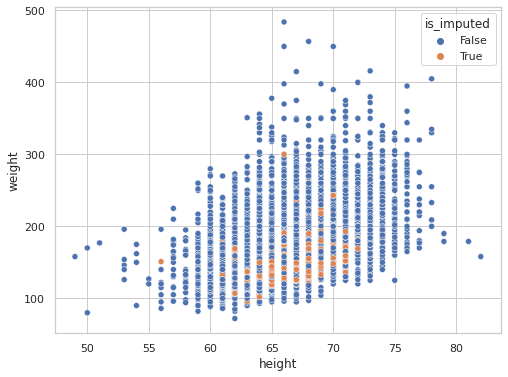

In [42]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

plt.show()

### Ordenamiento por cantidad de variables faltantes

In [43]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors = 10)

In [44]:
nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)
nhanes_df_knn.head()

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93703.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
93704.0,1.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
93705.0,0.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,0.0,13.0,100.0,189.0,2.0,NaN,NaN


In [45]:
nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round()

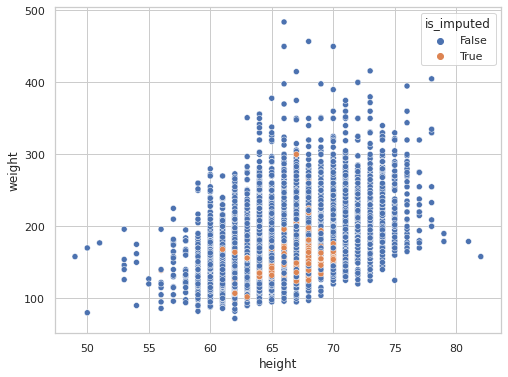

In [46]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

plt.show()

## Imputación basada en modelos

<ol>
    <li><i>Pros:</i></li>
        <ul>
            <li>Mejora sobre la imputación sencilla basada en donates.</li>
            <li>Variedad de opciones para imputar.</li>
            <li>Preservación de relaciones entre variables.</li>
        </ul>
    <li><i>Cons:</i></li>
        <ul>
            <li>Puede subestimar la varianza.</li>
            <li>Modelos funcionan mal si las variables observadas y faltantes son idependientes.</li>
            <li>Más complicado que la imputación basada en donante.</li>
        </ul>
</ol>

In [47]:
nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values(by = "height")
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix = "_imp"
    )
)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102939.0,NaN,107.0,Female,2.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False
102945.0,NaN,107.0,Male,15.0,True,False,False,False


In [48]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age",  data=df)
    )
    .fit()
)

In [49]:
ols_imputed_values = \
(
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

In [50]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values

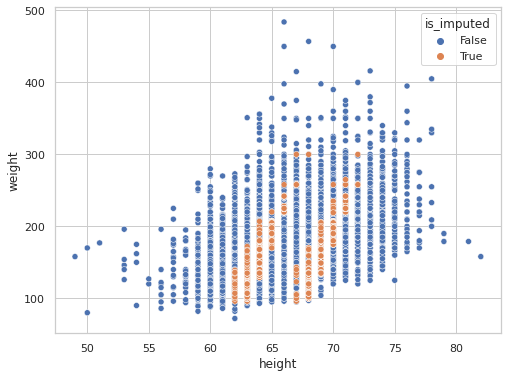

In [51]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

plt.show()

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

<ol>
    <li><i>Pros:</i></li>
        <ul>
            <li>Mantiene la distribución relativa similar antes y después de la imputación.</li>
            <li>Puede ser utlizada en cualquier tipo de análisis.</li>
            <li>Multiples variables son imputadas.</li>
        </ul>
    <li><i>Cons:</i></li>
        <ul>
            <li>Para funacionar bien, se debe pensar en el modelo de imputación y el modelo de análisis.</li>
            <li>Solo funciona como los métodos de imputación seleccionado.</li>
        </ul>
</ol>

In [52]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy='mean',
    imputation_order='ascending'
)

In [53]:
nhanes_mice_df = nhanes_transformed_df.copy(deep = True)

In [54]:
nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_mice_df).round()

In [55]:
nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
    ],
    axis = 1
)

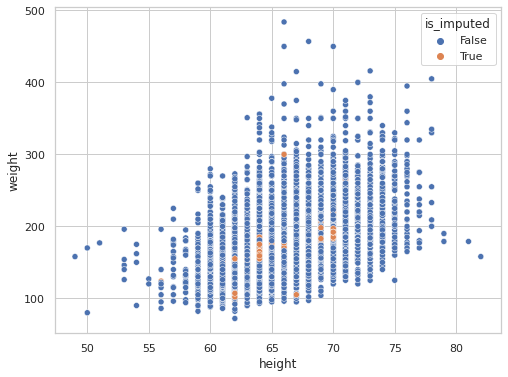

In [56]:
nhanes_mice_df.missing.scatter_imputation_plot(
    x = "height",
    y = "weight"
)

plt.show()

### Transformación inversa de los datos

In [57]:
nhanes_imputated_df = nhanes_mice_df.copy(deep=True)

In [59]:
categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['general_health_condition', 'gender'], dtype='object'))])

In [65]:
nhanes_imputated_df[categorical_columns] = \
(
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

In [67]:
nhanes_imputated_df.sample(10)

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age,height_imp,weight_imp,general_health_condition_imp,total_cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
100408.0,Good,Female,64.0,165.0,164.0,81.0,0.0,6.0,True,True,True,True,True
95463.0,Fair or,Male,66.0,220.0,197.0,62.0,0.0,19.0,False,False,False,False,False
96187.0,Good,Male,70.0,194.0,149.0,88.0,0.0,11.0,True,True,True,False,False
96860.0,Very good,Female,64.0,165.0,199.0,72.0,0.0,22.0,False,False,False,False,False
99901.0,Good,Female,63.0,247.0,186.0,74.0,0.0,36.0,False,False,False,False,False
102638.0,Excellent,Female,66.0,140.0,174.0,52.0,0.0,26.0,False,False,False,False,False
101658.0,Very good,Male,70.0,198.0,169.0,100.0,0.0,30.0,False,False,False,False,False
93997.0,Good,Female,64.0,165.0,168.0,82.0,0.0,11.0,True,True,True,True,False
100339.0,Good,Male,70.0,192.0,161.0,80.0,0.0,9.0,True,True,True,True,False


In [68]:
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [69]:
nhanes_imputated_df.general_health_condition.value_counts()

Good         4773
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [70]:
nhanes_mice_df.missing.number_missing()

0

## Información de sesión

In [71]:
session_info.show()